In [291]:
import tuw_nlp
tuw_nlp.download_alto()
tuw_nlp.download_definitions()

from xpotato.dataset.dataset import Dataset
from xpotato.models.trainer import GraphTrainer
from xpotato.models.utils import to_dot
from xpotato.graph_extractor.extract import FeatureEvaluator
from xpotato.dataset.utils import save_dataframe
from xpotato.dataset.utils import ud_to_graph
from xpotato.dataset.utils import default_pn_to_graph
from xpotato.dataset.utils import amr_pn_to_graph
from xpotato.graph_extractor.rule import RuleSet, Rule

from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import stanza
import os
from graphviz import Source
import pickle
import json
import numpy

stanza.download("en")
stanza.download("de")
stanza.download(lang="en",package=None,processors={"pos":"craft"})


2023-01-18 04:17:36,942 : common (424) - INFO - Downloading default packages for language: en (English)...
2023-01-18 04:17:38,408 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\default.zip.
2023-01-18 04:17:42,441 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-18 04:17:42,520 : common (424) - INFO - Downloading default packages for language: de (German)...
2023-01-18 04:17:44,164 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\de\default.zip.
2023-01-18 04:17:48,852 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-18 04:17:48,949 : common (446) - INFO - Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| pos       | craft   |
| pretrain  | craft   |

2023-01-18 04:17:49,009 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\pos\craft.pt.
2023-01-18 0

------------------------

## FoodDisease dataset

In [292]:
df = pd.read_csv(Path('../data/milestone3/preprocessed.csv'), sep=';')
df = df[df['source'] == 'FoodDisease']
df['prp_sent'] = df['prp_sent'].apply(lambda x: x.replace('term1', 'influence'). replace('term2', 'condition'))
df['sdp_joined'] = df['sdp_joined'].apply(lambda x: x.replace('term1', 'influence'). replace('term2', 'condition'))
# Only food disease because CrowdTruth is too bad quality
labels = df[['is_cause', 'is_treat']][df['source'] == 'FoodDisease']
print(len(labels))
print(labels.sum(axis=0))
df.head()

588
is_cause    132
is_treat    313
dtype: int64


,term1,term2,sentence,is_cause,is_treat,source,prp_sent,sdp,sdp_joined
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use influenc...","['term1', 'use', 'as', 'medicine', 'for', 'tre...",influence use as medicine for treatment of con...
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,influence consumption has been associated with...,"['term1', 'consumption', 'associate', 'with', ...",influence consumption associate with outcome a...
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,influence has notoriously been blamed for caus...,"['term1', 'blame', 'for', 'term2']",influence blame for condition
3,broiler chicken,footpad dermatitis,in broiler chicken flocks when animal-based me...,0,0,FoodDisease,in influence flocks when animal-based measures...,"['term1', 'flock', 'in', 'identify', 'burn', '...","influence flock in identify burn , condition"
4,sfp,diabetes,"in short, this study demonstrated that sfp cou...",0,1,FoodDisease,"in short, this study demonstrated that influen...","['term1', 'develop', 'as', 'food', 'or', 'prev...",influence develop as food or prevention of con...


In [293]:
def make_sentences(column="is_cause", df=df):
    sentences = []
    for i, row in df.iterrows():
        if row[column]:
            if column == "is_cause":
                relation = 'cause'
            else:
                relation="treat"
        else:
            relation = 'not'
        sentence = row['prp_sent'].encode('ascii', errors='ignore').decode('utf-8')
        sentences.append((sentence, relation))
    return sentences

### Full sentence

In [294]:
sentences_cause = make_sentences("is_cause", df)
sentences_treat = make_sentences("is_treat", df)

In [295]:
sentences_cause[1:5]

[('influence consumption has been associated with several health outcomes such as condition, hypertension, cardiovascular disease and cancer.',
  'cause'),
 ('influence has notoriously been blamed for causing an increase in the urinary excretion of calcium, and thus is a considered a risk factor for condition.',
  'cause'),
 ('in influence flocks when animal-based measures related to condition, hock burns, body lesions and arthritis are identified under commercial conditions (high density).',
  'not'),
 ('in short, this study demonstrated that influence could be developed as functional foods or pharmaceutical supplements for the prevention or mitigation of condition and its complications.',
  'not')]

In [296]:
dataset_cause = Dataset(sentences_cause, label_vocab={"not":0, "cause": 1}, lang="en")
dataset_treat = Dataset(sentences_treat, label_vocab={"not":0, "treat": 1}, lang="en")

In [297]:
# make graphs, slow on big dataet
#dataset_treat.set_graphs(dataset_treat.parse_graphs(graph_format="fourlang"))

In [298]:
# save dataframe
#df_treat = dataset_treat.to_dataframe()
#save_dataframe(df_treat, '../data/milestone3/df_treat_graphs_subset.tsv')

In [299]:
# make graphs, slow on big dataset
#dataset_cause.set_graphs(dataset_cause.parse_graphs(graph_format="fourlang"))

In [300]:
# save dataframe
#df_cause = dataset_cause.to_dataframe()
#save_dataframe(df_cause, '../data/milestone3/df_cause_graphs_subset.tsv')

In [301]:
# load dataframes
df_cause = pd.read_csv(Path('../data/milestone3/df_cause_graphs_subset.tsv'), sep='\t')
df_cause['graph'] = df_cause['graph'].apply(lambda x: amr_pn_to_graph(x)[0])

df_treat = pd.read_csv(Path('../data/milestone3/df_treat_graphs_subset.tsv'), sep='\t')
df_treat['graph'] = df_treat['graph'].apply(lambda x: amr_pn_to_graph(x)[0])

-----------------------------

POTATO framework uses both machine learning and rule-based systems in the way that ML is used to learn the rules, generate them. After the framework suggests the rules, based on feature importance, the user then decides whether to keep/adjust/discard the rule. The idea is to use subgraphs as features for training simple classifiers. Subgraphs are generated only up to a certain edge number.

### Treat relation

example graph for a sentence:

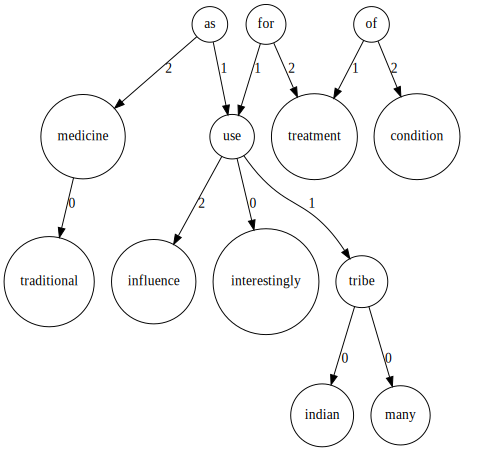

In [302]:
Source(to_dot(df_treat.iloc[0].graph))

#### Learning rules

First we will allow feature rules to contain no edges, meaning they can be just terms. We allow this by leaving the default value for min_edges=0 in trainer.prepare_and_train().

In [303]:
treat_train, treat_val = train_test_split(df_treat, test_size=0.2, random_state=1234)

trainer = GraphTrainer(treat_train)

treat_features = trainer.prepare_and_train()


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


470it [00:20, 23.21it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [304]:
treat_features["treat"][:10]

[(['(u_93 / reduce)'], [], 'treat'),
 (['(u_130 / prevent)'], [], 'treat'),
 (['(u_329 / improve)'], [], 'treat'),
 (['(u_31 / against)'], [], 'treat'),
 (['(u_543 / component)'], [], 'treat'),
 (['(u_362 / low)'], [], 'treat'),
 (['(u_134 / compound)'], [], 'treat'),
 (['(u_56 / decrease)'], [], 'treat'),
 (['(u_124 / potential)'], [], 'treat'),
 (['(u_669 / treat)'], [], 'treat')]

As expected, the best rules/features were just terms.

In [305]:
treat_evals, treat_acc = trainer.evaluator.evaluate_feature("treat", treat_features["treat"][:10], treat_train)

In [306]:
treat_evals[["Feature", "Precision", "Recall", "Fscore"]]


,Feature,Precision,Recall,Fscore
0,[(u_93 / reduce)],0.865385,0.177165,0.294118
1,[(u_130 / prevent)],1.000000,0.106299,0.192171
2,[(u_329 / improve)],1.000000,0.062992,0.118519
3,[(u_31 / against)],0.965517,0.110236,0.197880
4,[(u_543 / component)],0.947368,0.070866,0.131868
5,[(u_362 / low)],0.740741,0.078740,0.142349
6,[(u_134 / compound)],0.900000,0.070866,0.131387
7,[(u_56 / decrease)],0.818182,0.035433,0.067925
8,[(u_124 / potential)],0.857143,0.070866,0.130909
9,[(u_669 / treat)],0.888889,0.062992,0.117647


Let's see how many sentences match the top rules:

In [307]:
evaluator = FeatureEvaluator()

def subset_rule(df, rule_to_match):
    df_tmp = evaluator.match_features(df, rule_to_match)
    rows = []
    for i,row in df_tmp.iterrows():
        if row['Predicted label'] == 'treat':
            row['graph'] = df.iloc[i].graph
            rows.append(row)
    df_tmp = pd.DataFrame(rows, columns=['Sentence', 'Predicted label', 'Matched rule', 'graph']).reset_index(drop=True)
    return df_tmp


Reduce

In [308]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / reduce)"], [], "treat"]]
df_reduce = subset_rule(treat_train, rule_to_match)

470it [00:00, 1172.06it/s]


In [309]:
print("Reduce in "+str(len(df_reduce))+" sentences.")

Reduce in 52 sentences.


In [310]:
print("Example sentences:")
for i in range (3):
    print(df_reduce.iloc[i].Sentence+ "\n")

Example sentences:
influence and influence product intake is associated with better diet quality and has been associated with a reduced risk of condition or conditions including hypertension, cardiovascular disease, metabolic syndrome, type 2 diabetes and osteoporosis.

the mandatory fortification of enriched cereal grains (e.g., influence) with folic acid, which began in the united states in 1998, is an example of a successful intervention that significantly reduced the rate of condition (ntds).

epidemiological investigations have shown that consumption of soybeans or influence reduces the risk of the development of condition, cancer and osteoporosis.



Prevent

In [311]:
rule_to_match = [[["(u_1 / prevent)"], [], "treat"]]
df_prevent = subset_rule(treat_train, rule_to_match)

470it [00:00, 934.33it/s]


In [312]:
print("Prevent in "+str(len(df_prevent))+" sentences.")

Prevent in 27 sentences.


In [313]:
print("Example sentences:")
for i in range (3):
    print(df_prevent.iloc[i].Sentence+ "\n")

Example sentences:
we previously demonstrated that the consumption of iso--acids (iaa), the hop-derived bitter compounds in influence, prevents condition and alzheimer's disease pathology in model mice.

tea, influence and cocoa are good sources of flavanols and these highly consumed foods might contribute to prevent condition.

influence (rutaceae) is an easy-peeling citrus fruit, which has been used as a traditional korean medicine for improving skin elasticity, relieving condition and cough, and preventing bronchitis, flu, and various cancers.



Improve

In [314]:
rule_to_match = [[["(u_1 / improve)"], [], "treat"]]
df_improve = subset_rule(treat_train, rule_to_match)

470it [00:00, 1207.45it/s]


In [315]:
print("Improve in "+str(len(df_improve))+ " sentences.")

Improve in 16 sentences.


In [316]:
print("Example sentences:")
for i in range (3):
    print(df_improve.iloc[i].Sentence+ "\n")

Example sentences:
regular influence has been shown to improve blood pressure (bp), insulin sensitivity, and lipid levels in patients with condition (t2d), using up to 100 g of chocolate or 54 g of cocoa.

reports have shown that influence and avocado induce antioxidant and anti-inflammatory effects by improving enzymatic activity and modulating condition in the anti-inflammatory system in different tissues, without side effects.

influence (rutaceae) is an easy-peeling citrus fruit, which has been used as a traditional korean medicine for improving skin elasticity, relieving condition and cough, and preventing bronchitis, flu, and various cancers.



Against

In [317]:
rule_to_match = [[["(u_1 / against)"], [], "treat"]]
df_against = subset_rule(treat_train, rule_to_match)


470it [00:00, 883.19it/s] 


In [318]:
print("Against in "+str(len(df_against))+ " sentences.")

Against in 29 sentences.


In [319]:
print("Example sentences:")
for i in range (3):
    print(df_against.iloc[i].Sentence+ "\n")

Example sentences:
cell culture studies suggest that phytoestrogens, abundant in soy products such as tempe and influence, could protect against condition.

total phenolic extracts of influence are rich in dietary bioactive flavonoids, which show beneficial effects on liver health and are regarded as therapeutic tools against condition.

the results indicate that grape, soybean, green tea, influence, olive, and pomegranate are the most effective plants against condition.



Let's test it, we will define a ruleset from the top 5 rules/features:

In [320]:
# Create a ruleset from the features
feature1 = ['(u_0 / against)'], [], 'treat', [{'token': 0}]
feature2 = ['(u_0 / prevent)'], [], 'treat', [{'token': 0}]
feature3 = ['(u_0 / improve)'], [], 'treat', [{'token': 0}]
feature4 = ['(u_0 / reduce)'], [], 'treat', [{'token': 0}]
feature5 = ['(u_0 / component)'], [], 'treat', [{'token': 0}]

rule_set = RuleSet([Rule(feature1, openie=True), Rule(feature2, openie=True), Rule(feature3, openie=True), Rule(feature4, openie=True), Rule(feature5, openie=True)])# 

In [321]:
duos = []
for graph in treat_val.graph:
    duo= list(evaluator.annotate(graph, rule_set.to_list()))
    if len(duo) != 0:
        duos.append([duo[0]['relation'], duo[0]['token']])
    else:
        duos.append(["not", "-"])

d = {
            "Sentence": treat_val.text.tolist(),
            "True label": treat_val.label.tolist(),
            "Predicted label": [duo[0] for duo in duos],
            "Matched term": [duo[1] for duo in duos],
}
df = pd.DataFrame(data=d)

In [322]:
df

,Sentence,True label,Predicted label,Matched term
0,intake of beverages with excess free fructose ...,not,not,-
1,influence vegetables have been shown to have b...,treat,treat,against
2,there are limited data available regarding rel...,not,not,-
3,"many condition originating from, or carried by...",not,not,-
4,the pathogenic mechanism of influence conditio...,not,not,-
...,...,...,...,...
113,the reported incidence of condition is lower i...,treat,not,-
114,aeromonas salmonicida was isolated from condit...,not,not,-
115,influence products are believed to contain man...,treat,treat,against
116,a diet based on a adequate intake of calcium (...,treat,treat,reduce


In [323]:
def evalute_ruleset(df):
    tp = len(df[df['True label']=='treat'][df['Predicted label']=='treat'])
    tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
    fp = len(df[df['True label']=='not'][df['Predicted label']=='treat'])
    fn = len(df[df['True label']=='treat'][df['Predicted label']=='not'])
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return acc, precision, recall, f1

acc, precision, recall, f1 = evalute_ruleset(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']=='treat'][df['Predicted label']=='treat'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']=='treat'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']=='treat'][df['Predicted label']=='not'])


In [324]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.6864406779661016
Precision: 0.84375
Recall: 0.4576271186440678
F1: 0.5934065934065933


With 5 rules, in this case terms, we are able to determine the relation with 68.64% accuracy.

Let's expand the rules now by adding the restriction of min_edge = 1, meaning our rules will have to have more than a term.

In [325]:
treat_train, treat_val = train_test_split(df_treat, test_size=0.2, random_state=1234)

trainer = GraphTrainer(treat_train)

treat_features = trainer.prepare_and_train(min_edge = 1)


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


470it [00:18, 25.50it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [326]:
treat_features["treat"][:10]

[(['(u_31 / against  :2 (u_14 / condition))'], [], 'treat'),
 (['(u_117 / for  :2 (u_118 / treatment))'], [], 'treat'),
 (['(u_4 / of  :1 (u_200 / prevention))'], [], 'treat'),
 (['(u_130 / prevent  :2 (u_14 / condition))'], [], 'treat'),
 (['(u_29 / COORD  :0 (u_52 / acid))'], [], 'treat'),
 (['(u_4 / of  :1 (u_29 / COORD))'], [], 'treat'),
 (['(u_259 / on  :1 (u_18 / effect))'], [], 'treat'),
 (['(u_4 / of  :1 (u_118 / treatment  :2-of (u_117 / for)))'], [], 'treat'),
 (['(u_4 / of  :2 (u_29 / COORD)  :1 (u_118 / treatment))'], [], 'treat'),
 (['(u_4 / of  :1 (u_543 / component))'], [], 'treat')]

Creating a ruleset:

In [327]:
# Create a ruleset from the features, we will define our ruleset with 5 of the best features
feature1 = ['(u_0 / against  :2 (u_1 / condition))'], [], 'treat', [{'term': 0}]
feature2 = ['(u_0 / for  :2 (u_1 / treatment))'], [], 'treat', [{'term': 0}]
feature3 = ['(u_0 / of  :1 (u_1 / prevention))'], [], 'treat', [{'term': 0}]
feature4 = ['(u_0 / prevent  :2 (u_1 / condition))'], [], 'treat', [{'term': 0}]
feature5 = ['(u_0 / COORD  :0 (u_1 / acid))'], [], 'treat', [{'term': 0}]

rule_set = RuleSet([Rule(feature1, openie=True), Rule(feature2, openie=True), Rule(feature3, openie=True), Rule(feature4, openie=True), Rule(feature5, openie=True)])# 

In [328]:
duos = []
for graph in treat_val.graph:
    duo= list(evaluator.annotate(graph, rule_set.to_list()))
    if len(duo) != 0:
        duos.append([duo[0]['relation'], duo[0]['term']])
    else:
        duos.append(["not", "-"])

d = {
            "Sentence": treat_val.text.tolist(),
            "True label": treat_val.label.tolist(),
            "Predicted label": [duo[0] for duo in duos],
            "Matched term": [duo[1] for duo in duos],
}
df = pd.DataFrame(data=d)

In [329]:
df

,Sentence,True label,Predicted label,Matched term
0,intake of beverages with excess free fructose ...,not,not,-
1,influence vegetables have been shown to have b...,treat,not,-
2,there are limited data available regarding rel...,not,not,-
3,"many condition originating from, or carried by...",not,not,-
4,the pathogenic mechanism of influence conditio...,not,not,-
...,...,...,...,...
113,the reported incidence of condition is lower i...,treat,not,-
114,aeromonas salmonicida was isolated from condit...,not,not,-
115,influence products are believed to contain man...,treat,treat,against
116,a diet based on a adequate intake of calcium (...,treat,not,-


In [330]:
def evalute_ruleset(df):
    tp = len(df[df['True label']=='treat'][df['Predicted label']=='treat'])
    tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
    fp = len(df[df['True label']=='not'][df['Predicted label']=='treat'])
    fn = len(df[df['True label']=='treat'][df['Predicted label']=='not'])
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return acc, precision, recall, f1

acc, precision, recall, f1 = evalute_ruleset(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']=='treat'][df['Predicted label']=='treat'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']=='treat'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\1011948190.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']=='treat'][df['Predicted label']=='not'])


In [331]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.5423728813559322
Precision: 0.7272727272727273
Recall: 0.13559322033898305
F1: 0.2285714285714286


As expected, by making the rules more specific the results have dropped a bit with accuracy = 54.24%.

### Cause relation

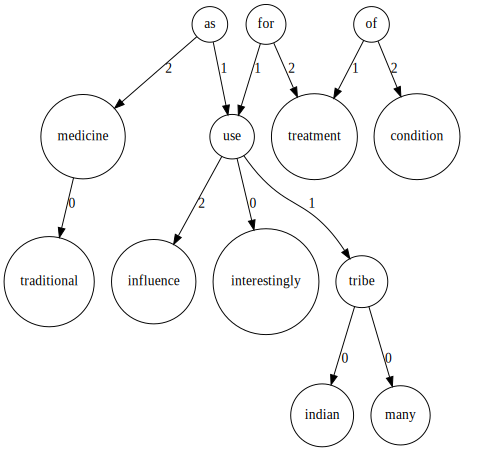

In [332]:
Source(to_dot(df_cause.iloc[0].graph))


### Learning rules


In [333]:
cause_train, cause_val = train_test_split(df_cause, test_size=0.2, random_state=1234)

trainer = GraphTrainer(cause_train)

cause_features = trainer.prepare_and_train()


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


470it [00:16, 29.23it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [334]:
cause_features["cause"][:10]


[(['(u_47 / increase)'], [], 'cause'),
 (['(u_340 / patient)'], [], 'cause'),
 (['(u_352 / protein)'], [], 'cause'),
 (['(u_287 / exposure)'], [], 'cause'),
 (['(u_215 / fat)'], [], 'cause'),
 (['(u_29 / COORD  :0 (u_26 / product))'], [], 'cause'),
 (['(u_798 / among)'], [], 'cause'),
 (['(u_117 / for  :2 (u_14 / condition))'], [], 'cause'),
 (['(u_295 / however)'], [], 'cause'),
 (['(u_37 / consume)'], [], 'cause')]

In [335]:
cause_evals, cause_acc = trainer.evaluator.evaluate_feature("cause", cause_features["cause"][:10], cause_train)


In [336]:
cause_evals[["Feature", "Precision", "Recall", "Fscore"]]


,Feature,Precision,Recall,Fscore
0,[(u_47 / increase)],0.636364,0.198113,0.302158
1,[(u_340 / patient)],0.388889,0.066038,0.112903
2,[(u_352 / protein)],0.428571,0.056604,0.100000
3,[(u_287 / exposure)],0.727273,0.075472,0.136752
4,[(u_215 / fat)],0.500000,0.056604,0.101695
5,[(u_29 / COORD :0 (u_26 / product))],0.500000,0.047170,0.086207
6,[(u_798 / among)],0.666667,0.075472,0.135593
7,[(u_117 / for :2 (u_14 / condition))],0.333333,0.056604,0.096774
8,[(u_295 / however)],0.454545,0.047170,0.085470
9,[(u_37 / consume)],0.300000,0.028302,0.051724


Let's again see how many sentences match the top rules:

Increase

In [337]:
rule_to_match = [[["(u_1 / increase)"], [], "treat"]]
df_increase = subset_rule(cause_train, rule_to_match)

470it [00:00, 1099.49it/s]


In [339]:
print("Increase in "+str(len(df_increase))+" sentences")

Increase in 33 sentences


In [340]:
for i in range (3):
    print(df_increase.iloc[i].Sentence+ "\n")

the decreasing mortality rates from condition are thought to reflect the increases in animal foods, milk, and dairy products and consequently in saturated fatty acids and calcium, together with a decrease in influence intake which may have led to a decrease in blood pressure.

however, the other ubiquitous white crystal, influence, may lead to condition by increasing inflammation, hyperinsulinemia, increased renal acid load, reduced calcium intake, and increased urinary calcium excretion.

recent evidence has also suggested carnitine from influence, as a precursor for trimethylamine-n-oxide, which has been shown to cause condition, may increase the risk of suffering cvd in experimental animals.



Patient

In [341]:
rule_to_match = [[["(u_1 / patient)"], [], "treat"]]
df_patient = subset_rule(cause_train, rule_to_match)


470it [00:00, 1330.71it/s]


In [342]:
print("Patient in "+str(len(df_patient))+" sentences")

Patient in 18 sentences


In [343]:
for i in range (3):
    print(df_patient.iloc[i].Sentence+ "\n")

regular influence has been shown to improve blood pressure (bp), insulin sensitivity, and lipid levels in patients with condition (t2d), using up to 100 g of chocolate or 54 g of cocoa.

this study reports the effect of influence on ua in condition patients.

influence, which are rich in anti-inflammatory and antioxidative bioactive compounds, are proposed to be efficacious in preventing and treating condition, but recommendations to patients are conflicting.



Protein

In [344]:
rule_to_match = [[["(u_1 / protein)"], [], "treat"]]
df_protein = subset_rule(cause_train, rule_to_match)

470it [00:00, 1328.65it/s]


In [345]:
print("Protein in "+str(len(df_protein))+" sentences")

Protein in 14 sentences


In [346]:
for i in range (3):
    print(df_protein.iloc[i].Sentence+ "\n")

influence and cashew contain allergenic proteins, which causes them to be removed from the diet of condition people.

in influence condition, proteins with molecular masses of 14-16, 26, 33, and 56 kda have been demonstrated to be potentially allergenic.

the consumption of dairy products by older people may reduce the risk of frailty, especially with high consumption of low-fat milk and yogurt, and may also reduce the risk of condition by improving skeletal muscle mass through the addition of nutrient-rich dairy proteins (ricotta influence) to the habitual diet.



Exposure

In [347]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / exposure)"], [], "treat"]]
df_exposure = subset_rule(cause_train, rule_to_match)

470it [00:00, 1371.06it/s]


In [348]:
print("Exposure in "+ str(len(df_exposure))+" sentences")

Exposure in 11 sentences


In [349]:
for i in range (3):
    print(df_exposure.iloc[i].Sentence+ "\n")

bronchial provocation tests by "occupational" exposure to influence provoked dual condition accompanied by rhinitis in two atopic bakers engaged in the manufacture of bread and pies.

we estimated the association between occupational exposures to five different organic dusts: wood, animal, paper, textile and influence and the risk of condition (ra).

condition could be induced by inhaled influence or by exposure to allergens present in bakery products.



Fat

In [350]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / fat)"], [], "treat"]]
df_fat = subset_rule(cause_train, rule_to_match)

470it [00:00, 1046.78it/s]


In [351]:
print("Fat in "+ str(len(df_fat)) +" sentences")

Fat in 12 sentences


In [352]:
for i in range (3):
    print(df_fat.iloc[i].Sentence+ "\n")

the origin of condition is multifactorial, and many metabolic disorders originating from overconsumption of fat, cholesterol, and influence are associated with higher risk of condition later in life.

their diets differ in the amount of total fat, influence, type of meat and wine intake; milk vs. cheese; fruits and vegetables; and the rates of condition and cancer, with the lower death rates and longer life expectancy occurring in greece.

influence cultivar have been reported to reduce body fat mass, promote metabolism, and improve unidentified complaints of condition.



Let's test it, we will define a ruleset from the top 5 rules/features:

In [358]:
# Create a ruleset from the features
feature1 = ['(u_0 / increase)'], [], 'cause', [{'token': 0}]
feature2 = ['(u_0 / patient)'], [], 'cause', [{'token': 0}]
feature3 = ['(u_0 / protein)'], [], 'cause', [{'token': 0}]
feature4 = ['(u_0 / exposure)'], [], 'cause', [{'token': 0}]
feature5 = ['(u_0 / fat)'], [], 'cause', [{'token': 0}]

rule_set = RuleSet([Rule(feature1, openie=True), Rule(feature2, openie=True), Rule(feature3, openie=True), Rule(feature4, openie=True), Rule(feature5, openie=True)])# 

In [359]:
duos = []
for graph in cause_val.graph:
    duo= list(evaluator.annotate(graph, rule_set.to_list()))
    if len(duo) != 0:
        duos.append([duo[0]['relation'], duo[0]['token']])
    else:
        duos.append(["not", "-"])

d = {
            "Sentence": cause_val.text.tolist(),
            "True label": cause_val.label.tolist(),
            "Predicted label": [duo[0] for duo in duos],
            "Matched term": [duo[1] for duo in duos],
}
df = pd.DataFrame(data=d)

In [360]:
df

,Sentence,True label,Predicted label,Matched term
0,intake of beverages with excess free fructose ...,cause,not,-
1,influence vegetables have been shown to have b...,not,not,-
2,there are limited data available regarding rel...,not,not,-
3,"many condition originating from, or carried by...",not,not,-
4,the pathogenic mechanism of influence conditio...,not,not,-
...,...,...,...,...
113,the reported incidence of condition is lower i...,not,not,-
114,aeromonas salmonicida was isolated from condit...,not,not,-
115,influence products are believed to contain man...,not,not,-
116,a diet based on a adequate intake of calcium (...,not,cause,protein


In [361]:
def evalute_ruleset_cause(df):
    tp = len(df[df['True label']=='cause'][df['Predicted label']=='cause'])
    tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
    fp = len(df[df['True label']=='not'][df['Predicted label']=='cause'])
    fn = len(df[df['True label']=='cause'][df['Predicted label']=='not'])
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return acc, precision, recall, f1

acc, precision, recall, f1 = evalute_ruleset_cause(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\3524534850.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']=='cause'][df['Predicted label']=='cause'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\3524534850.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\3524534850.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']=='cause'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_2848\3524534850.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']=='cause'][df['Predicted label']=='not'])


In [362]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.7457627118644068
Precision: 0.35714285714285715
Recall: 0.19230769230769232
F1: 0.25


With 5 rules, in this case terms, we are able to determine the relation with 74.58% accuracy.